#### Load Libraries ####

In [46]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.backend import backend

from __future__ import print_function

import os
import re

import numpy as np
import PIL
from PIL import Image

from scipy.stats import randint as sp_randint

import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential,Model
from keras.layers import Dense, Convolution2D, AveragePooling2D, MaxPooling2D, Flatten, Activation, UpSampling2D, Add, merge, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model
from keras.applications.imagenet_utils import decode_predictions
from keras.preprocessing import image as im
from keras.callbacks import Callback

from keras.models import model_from_json

import tensorflow as tf
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

%matplotlib inline

    

In [36]:
import glob
from skimage import color
import scipy

def preprocess_single_image(img_name, datagen):
    image = plt.imread(img_name)
    
    if image.shape[0] > image.shape[1]:
        offset = int((image.shape[0] - image.shape[1]) / 2 + 1)
        image = image[offset:image.shape[1]+offset,:,:]
    elif image.shape[0] < image.shape[1]:
        offset = int((image.shape[1] - image.shape[0]) / 2 + 1)
        image = image[:,offset:image.shape[0]+offset,:]

    #resize
    image = scipy.misc.imresize(image, (224, 224), interp='bilinear')
    
    #random transform using data generators functions
    image = datagen.random_transform(image)
    
    return image

def preprocess_images(image_names, seed, datagen):
    np.random.seed(seed)
    images=[]
    for img_name in image_names:
        image = preprocess_single_image(img_name, datagen)
        images.append(image)
    return images



''' Convert color images to gray scales, color images to HUV format,
    return grayscale RGB image and UV channels of color image 
'''
def data_generator(image_name_path,batchsize):
    image_names = glob.glob(image_name_path)
    
    datagen_args = dict(rotation_range=10,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        
                    )
    datagen = ImageDataGenerator(**datagen_args)
    seed = 1000
    
    while 1:
        batch = np.random.choice(image_names, batchsize,replace=False)
        rgbImages = preprocess_images(batch,seed,datagen)
        grayScales = [ color.gray2rgb(color.rgb2gray(i)) for i in rgbImages]
        
        yuvColor = [ color.rgb2yuv(i) for i in rgbImages]
        #yuvGray = [ color.rgb2yuv(i) for i in grayScales]
        
        grayScale_arr = np.array(grayScales)
        
        #grayScale_arr = preprocess_input(grayScale_arr)
        #yuvGray_arr = np.array(yuvGray)
        #yuvGray_arr[:,:,:,1:] = 0
        
        yuvColor_arr = np.array(yuvColor)[:,:,:,1:]
        
        yield grayScale_arr, yuvColor_arr
    
    

### Build Neural Net ###

##### Load Pretrained VGG16 Model #####

In [8]:
model = applications.VGG16(weights = "imagenet", include_top=True, input_shape = (224, 224, 3))

In [9]:
def buildModel_baseVGG16(vgg16_model):
    model = vgg16_model
    layer = model.get_layer(name='block4_conv3')
    #layer
    x = BatchNormalization(name='n0')(layer.output)
    y = Convolution2D(filters=256, kernel_size=1, activation='tanh', name='c1')(x)

    y = UpSampling2D(name = 'up1', size=2)(y)
    x = BatchNormalization(name='n1')(model.get_layer(name='block3_conv3').output)
    z = merge((x,y), mode='concat', name='s1')
    #z = Concatenate((x,y))
    y = Convolution2D(filters=128, kernel_size=3, strides=1, activation='tanh', name='c2',padding='same')(z)

    y = UpSampling2D(name = 'up2', size=2)(y)
    x = BatchNormalization(name='n2')(model.get_layer(name='block2_conv2').output)
    z = merge((x,y), mode='concat', name='s2')
    y = Convolution2D(filters=64, kernel_size=3, strides=1, activation='tanh', name='c3',padding='same')(z)

    y = UpSampling2D(name = 'up3', size=2)(y)
    x = BatchNormalization(name='n3')(model.get_layer(name='block1_conv2').output)
    z = merge((x,y), mode='concat', name='s3')
    y = Convolution2D(filters=3, kernel_size=3, strides=1, activation='tanh', name='c4',padding='same')(z)

    x = BatchNormalization(name='n4')(model.get_layer(name=model.input_names[0]).output)
    z = merge((x,y), mode='concat', name='s4')
    y = Convolution2D(filters=3, kernel_size=3, strides=1, activation='tanh', name='c5',padding='same')(z)

    y = Convolution2D(filters=2, kernel_size=3, name='output', padding='same', activation='tanh')(y)

    model_final = Model(input = model.input, output = y)
    
    return model_final


In [10]:
model_final = buildModel_baseVGG16(model)
#model.get_layer(name=model.input_names[0]).output
model_final.summary()

/Users/cooldude/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/cooldude/anaconda/lib/python3.6/site-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/Users/cooldude/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:16: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/cooldude/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/cooldude/anaconda/lib

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 224, 224, 64)  1792                                         
____________________________________________________________________________________________________
block1_conv2 (Conv2D)            (None, 224, 224, 64)  36928                                        
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0                                            
___________________________________________________________________________________________

##### Visualize Model #####

In [11]:
from IPython.display import SVG
import logging
from keras.utils.vis_utils import model_to_dot #, plot
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

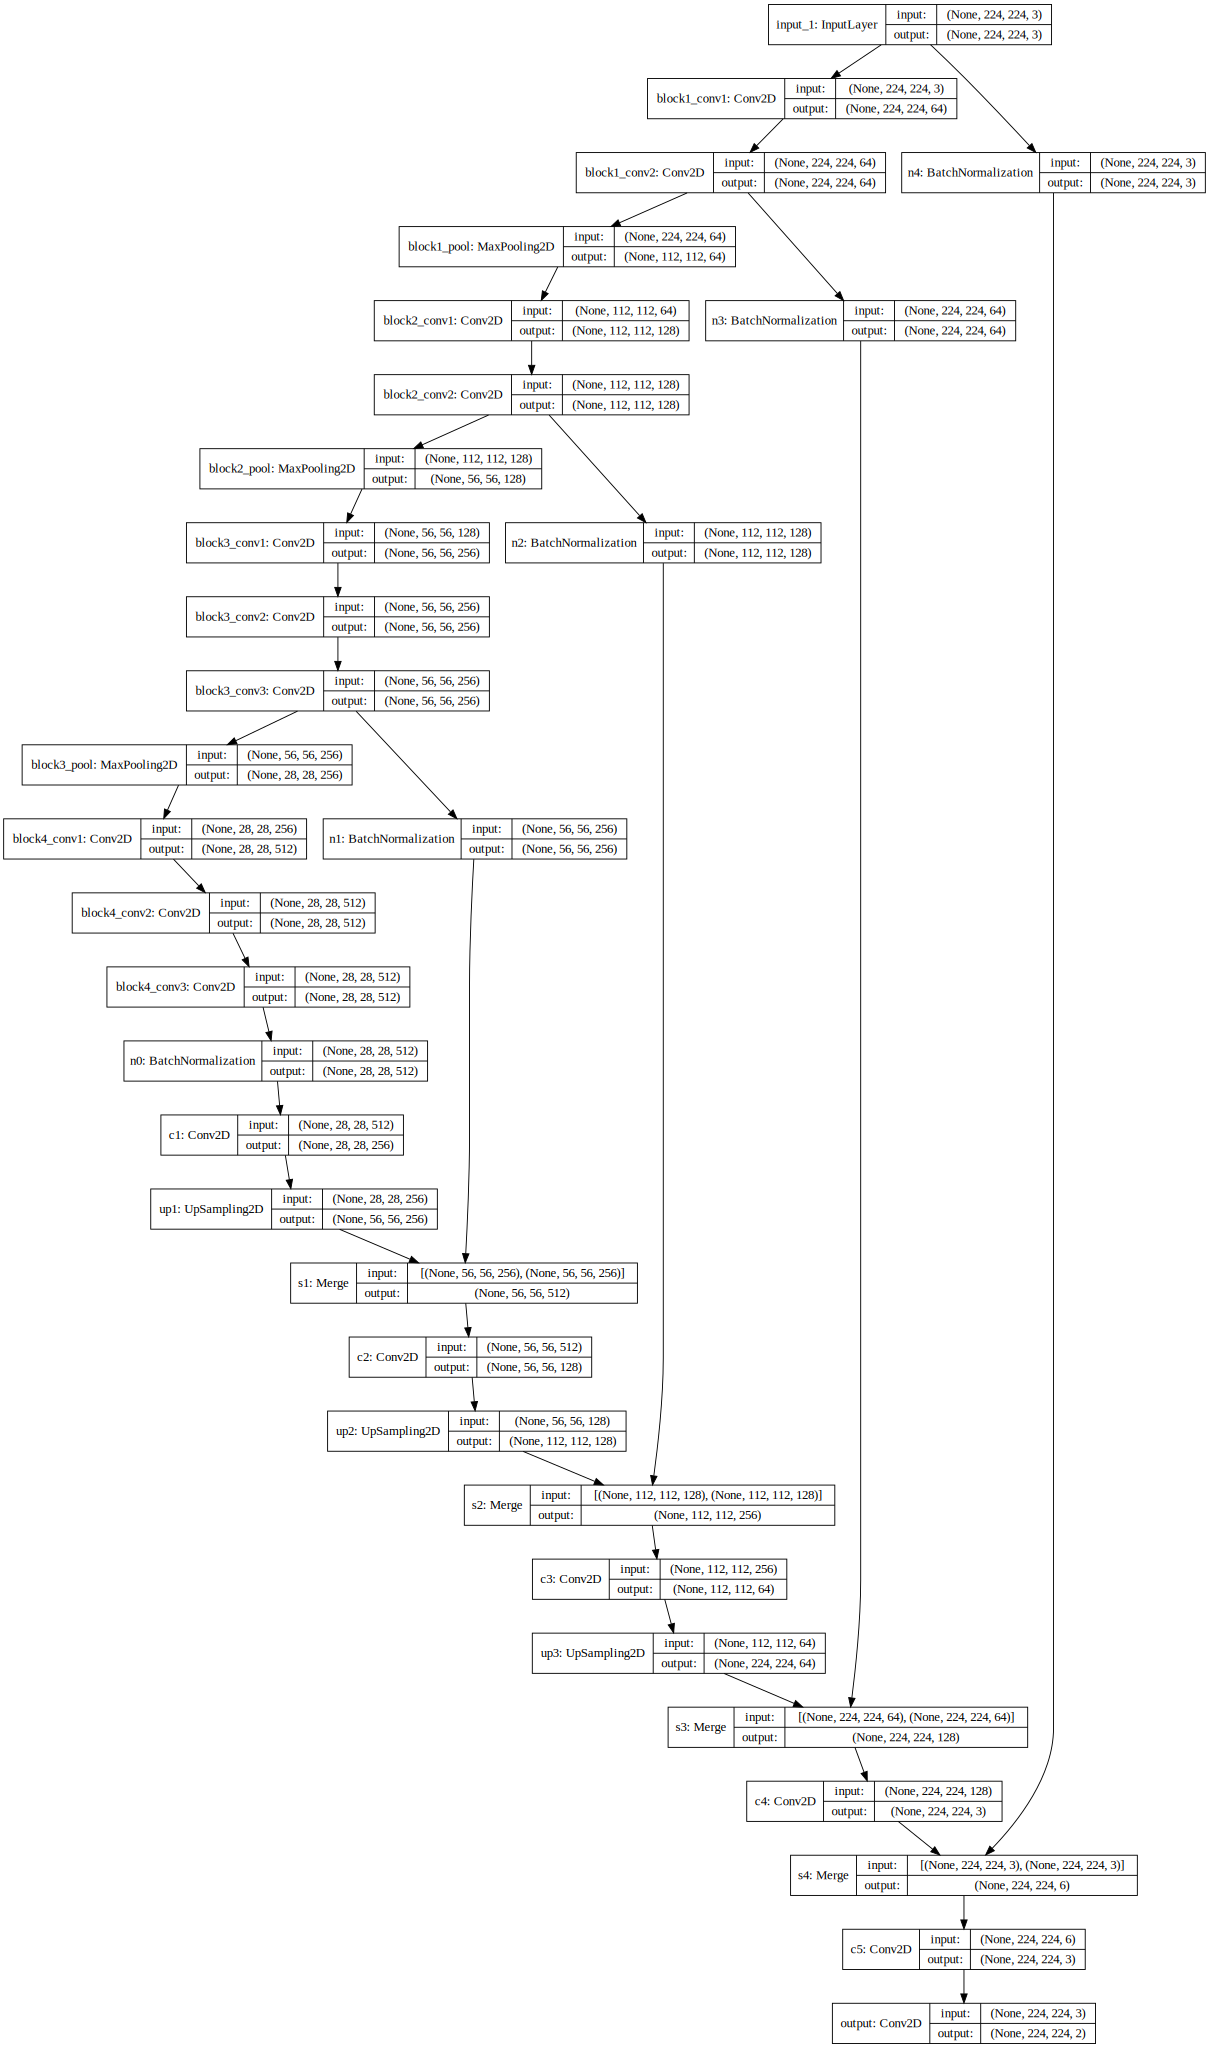

In [12]:
SVG(model_to_dot(model_final, show_shapes=True).create(prog='dot', format='svg'))

##### Compile Model #####

In [13]:
model_final.compile(loss="mean_squared_error", optimizer="adam")

#### Save Model ####

In [27]:
def saveModelAndWeights(model, filePrefix):
    model_json = model.to_json()
    with open(filePrefix + "_model.json", "w") as json_file:
        json_file.write(model_json)
    
    # serialize weights to HDF5
    model.save_weights(filePrefix + "_weights.h5")
    print("Saved model to disk")
    
def loadModel(filePrefix):
    with open(filePrefix + '_model.json', 'r') as json_file:
        loaded_model_json = json_file.read()

    loaded_model = model_from_json(loaded_model_json)
    
    # load weights into new model
    loaded_model.load_weights(filePrefix + "_weights.h5")
    
    print("Loaded model from disk")
    
    return(loaded_model)

In [28]:
saveModelAndWeights(model_final, filePrefix='initialWithTanhActivation')

Saved model to disk


In [29]:
loaded_model = loadModel('initialWithTanhActivation')

/Users/cooldude/anaconda/lib/python3.6/site-packages/keras/engine/topology.py:1206: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


Loaded model from disk


#### Train Model ###

In [57]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        with open('losses.log', 'w') as lossLog:
            lossLog.write('')

    def on_batch_end(self, batch, logs={}):
        #self.losses.append(logs.get('loss'))
        with open('losses.log', 'a') as lossLog:
            lossLog.write(logs.get('loss').tostring())


In [58]:
# Define callback to save model checkpoints
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')
model_checkpoint = ModelCheckpoint(os.path.join('checkpoints', 'weights.{epoch:02d}-{val_loss:.5f}.hdf5'),
                                  monitor='loss', save_best_only=True)

# Define callback to reduce learning rate when learning stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, epsilon=0.0001, cooldown=1)

# TensorBoard visualization
#tensorboard = TensorBoard(log_dir='logs/tboard_logs2', histogram_freq=0, write_graph=True, write_images=True)

csv_logger = CSVLogger('train_log.csv', separator=',', append=True)
lossHistory = LossHistory()
# Train the model
# model = get_unet(0.001)
# model_fin.fit(X_train, Y_train, batch_size=32, epochs=NUM_EPOCHS, verbose=1, shuffle=True,
#          callbacks=[model_checkpoint, reduce_lr, tensorboard], validation_data=(X_val, Y_val))

In [66]:
TRAIN_IMAGE_PATH = 'data/flickr30k-images/*.jpg'
VALIDATION_IMAGE_NAME_PATH = 'data/flickr30k-images_validation/*.jpg'

#TRAIN_IMAGE_PATH = 'images/*.jpg'
#VALIDATION_IMAGE_NAME_PATH = 'validationImages/*.jpg'



BATCH_SIZE = 10
VALIDATION_BATCH_SIZE = int(BATCH_SIZE * .1)
NUM_EPOCHS = 1
TRAIN_STEPS_PER_EPOCH = len(glob.glob(TRAIN_IMAGE_PATH))// BATCH_SIZE
VALIDATION_STEPS_PER_EPOCH = len(glob.glob(VALIDATION_IMAGE_NAME_PATH))// VALIDATION_BATCH_SIZE

train_Gen = data_generator(TRAIN_IMAGE_PATH,BATCH_SIZE)
validation_dGen = data_generator(VALIDATION_IMAGE_NAME_PATH,VALIDATION_BATCH_SIZE)



In [ ]:
history = model_final.fit_generator(
generator=train_Gen,
steps_per_epoch = TRAIN_STEPS_PER_EPOCH,
epochs = 1,
validation_data = validation_dGen,
#nb_val_samples = 20,
verbose = 1,
validation_steps = VALIDATION_STEPS_PER_EPOCH,
callbacks = [model_checkpoint, reduce_lr, csv_logger],
workers=1)

Epoch 1/1
 5/21 [======>.......................] - ETA: 556s - loss: 0.0117

In [79]:
#dat = plt.imread('../flickr30k-images/1000092795.jpg')

colorImg=preprocess_single_image('data/flickr30k-images_validation/', ImageDataGenerator())
#plt.imshow(dat)

grayImg = color.rgb2gray(colorImg)
grayImg3Ch = np.zeros(colorImg.shape)
grayImg3Ch[:,:,0] = grayImg
grayImg3Ch[:,:,1] = grayImg
grayImg3Ch[:,:,2] = grayImg

yuvColorImg = color.rgb2yuv(colorImg)
yuvGrayImg = np.zeros(colorImg.shape)
yuvGrayImg[:,:,0] = yuvColorImg[:,:,0]


In [89]:
uvResult = model_final.predict(np.expand_dims(grayImg3Ch,0))
print(np.min(uvResult),np.max(uvResult))

-0.728931 0.636663


(-0.5, 0.5)

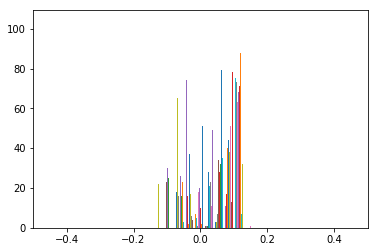

In [86]:
plt.hist(yuvColorImg[:,:,1])
plt.xlim(-.5,.5)

(-0.5, 0.5)

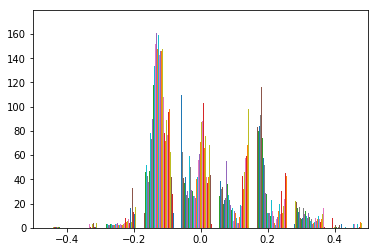

In [87]:
plt.hist(uvResult[0,:,:,1])
plt.xlim(-.5,0.5)

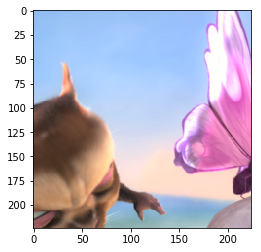

In [73]:
plt.imshow(colorImg)

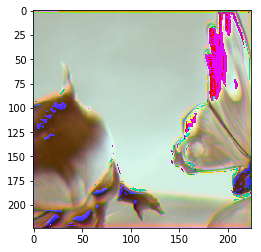

In [95]:
pred_YUVImg = np.zeros(colorImg.shape)
pred_YUVImg[:,:,0] = yuvColorImg[:,:,0]
pred_YUVImg[:,:,1] = uvResult[0,:,:,0]
pred_YUVImg[:,:,2] = uvResult[0,:,:,1]

pred_YUVImg[pred_YUVImg[:,:,1]>0.5,1] = 0.5
pred_YUVImg[pred_YUVImg[:,:,1]<(-0.5),1] = -0.5

pred_YUVImg[pred_YUVImg[:,:,2]>0.5,2] = 0.49999
pred_YUVImg[pred_YUVImg[:,:,2]<(-0.5),2] = -0.49999

plt.imshow(color.yuv2rgb(pred_YUVImg))

In [ ]:
# from twilio.rest import Client

# # Find these values at https://twilio.com/user/account
# account_sid = "ACXXXXXXXXXXXXXXXXX"
# auth_token = "YYYYYYYYYYYYYYYYYY"
# client = Client(account_sid, auth_token)

# message = client.api.account.messages.create(to="+12316851234",
#                                              from_="+15555555555",
#                                              body="Hello there!")